In [111]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys, os

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import scipy.constants as cst 

import scqubits as scq
import qutip as qt
import qutip.visualization as qplt

from PulseSequence import PulseSequence
from QSwitch import QSwitchTunableTransmonCoupler, QSwitchSNAIL

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = [None, 'o', '.', 's', '*', '^']
# scq.settings.PROGRESSBAR_DISABLED = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Plotting functions

# Tunable transmon

In [2]:
def EJ_flux(EJmax, phi_ext, dEJ): # phi_ext in units of phi0
    return EJmax * np.sqrt(np.cos(np.pi*phi_ext)**2 + dEJ**2 * np.sin(np.pi*phi_ext)**2)

In [48]:
cutoffs = [5, 5, 5, 5, 5]
# cutoffs = [3]*5

# # good:
# EJs = np.array([15, 21, 16]) # GHz
# ECs = np.array([0.130, 0.170, 0.110]) # GHz
# dEJ = 0.3 # (EJ1 - EJ2)/(EJ1 + EJ2)
# gs =  1e-3*np.array([5, 300, 300]) # GHz gs=[01, 0c, 1c]

# good:
# EJs = np.array([12.5, 16.5, 34]) # GHz
# ECs = np.array([0.110, 0.130, 0.250]) # GHz
# dEJ = 0.35 # (EJ1 - EJ2)/(EJ1 + EJ2)
# gs =  1e-3*np.array([5, 300, 300]) # gs=[01, 0c, 1c]

# good:
# EJs = np.array([15.5, 25, 18]) # GHz
# ECs = np.array([0.130, 0.180, 0.110]) # GHz
# dEJ = 0.35 # (EJ1 - EJ2)/(EJ1 + EJ2)
# gs =  1e-3*np.array([5, 250, 350]) # gs=[01, 0c, 1c]

# good:
# EJs = np.array([27.5, 25.3, 36.3]) # GHz
# ECs = np.array([0.200, 0.150, 0.100]) # GHz
# dEJ = 0.30 # (EJ1 - EJ2)/(EJ1 + EJ2)
# gs =  1e-3*np.array([25.6, 315, -252]) # gs=[01, 0c, 1c]

EJs = np.array([27.5, 25.3, 32.0]) # GHz
ECs = np.array([0.190, 0.150, 0.115]) # GHz
dEJ = 0.30 # (EJ1 - EJ2)/(EJ1 + EJ2)
gs =  1e-3*np.array([25.6, 315, -252]) # gs=[01, 0c, 1c]

# # good:
# EJs = np.array([25, 22, 24]) # GHz
# ECs = np.array([0.120, 0.110, 0.090]) # GHz
# dEJ = 0.3 # (EJ1 - EJ2)/(EJ1 + EJ2)
# gs =  1e-3*np.array([20, 300, -190]) # gs=[01, 0c, 1c]



print('AT FLUX 0')
phi_ext = 0.0
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=True,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], EJ_flux(EJs[-1], phi_ext, dEJ)]/ECs))

# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

print()
print('AT FLUX 0.5')
phi_ext = 0.5
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=True,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], EJ_flux(EJs[-1], phi_ext, dEJ)]/ECs))


AT FLUX 0
bare qubit freqs (GHz) 6.269224812331871 5.355582899572795 5.308279496601351
bare alphas (GHz) -0.2045652484472189 -0.16052334126089818 -0.12107959858667527
EJ/EC 144.73684210526315 168.66666666666669 278.2608695652174

AT FLUX 0.5
bare qubit freqs (GHz) 6.269224812331871 5.355582899572795 2.851889346038316
bare alphas (GHz) -0.2045652484472189 -0.16052334126089818 -0.12726797557825797
EJ/EC 144.73684210526315 168.66666666666669 83.4782608695652


### Minimize ZZ

In [49]:
ZZ_01_flux = []
phi_exts = np.linspace(-0.25, 0.75, num=200)
evals_flux = []

for phi_ext_i in tqdm(phi_exts):
    qram = QSwitchTunableTransmonCoupler(
        EJs=EJs,
        ECs=ECs,
        dEJ=dEJ,
        phi_ext=phi_ext_i,
        gs=gs,
        is2Q=True,
        cutoffs=cutoffs,
        useZZs=False,
    )
    evals, evecs = qram.esys
    evals_flux.append(evals)
    ZZ_01_flux.append(qram.get_ZZ(0, 1))
ZZ_01_flux = np.array(ZZ_01_flux)
evals_flux = np.array(evals_flux)

100%|██████████| 200/200 [00:11<00:00, 16.84it/s]


Calculate effective iSWAP rabi rate: https://journals.aps.org/pra/pdf/10.1103/PhysRevA.96.062323

In [50]:
drive_strength = 0.05 # units of flux quanta

g0c = gs[-qram.nqubits + 1]
g1c = gs[-qram.nqubits + 2]

wq0 = np.sqrt(8*ECs[0]*EJs[0])
wq1 = np.sqrt(8*ECs[1]*EJs[1])
wc_flux = np.sqrt(8*ECs[1]*EJs[1])*np.sqrt(np.abs(np.cos(np.pi*phi_exts)))

assert (phi_exts[-1] - phi_exts[0]) == int(phi_exts[-1] - phi_exts[0]) # need periodic time conditions
dwcdflux = []
for i in range(len(phi_exts)):
    dphi = phi_exts[1] - phi_exts[0]
    dwcdflux.append((wc_flux[(i+1)%(len(phi_exts)-1)] - wc_flux[(i-1)%(len(phi_exts)-1)]) / 2/dphi)
dwcdflux = np.array(dwcdflux)

Del_0minus_flux = wq0 - wc_flux
Del_1minus_flux = wq1 - wc_flux
Del_0plus_flux = wq0 + wc_flux
Del_1plus_flux = wq1 + wc_flux
Omega_eff_flux = drive_strength*g0c*g1c/4 * dwcdflux * (1/(Del_0minus_flux * Del_1minus_flux) + 1/(Del_0plus_flux * Del_1plus_flux)) # applying drive at Phi = Phi0 + drive_strength * cos(w_mod t)

Min ZZ (MHz) -0.041909788947691595 at phi_ext/phi0 0.49874371859296485
Max ZZ (MHz) -26.866499296289703 at phi_ext/phi0 0.0012562814070351536


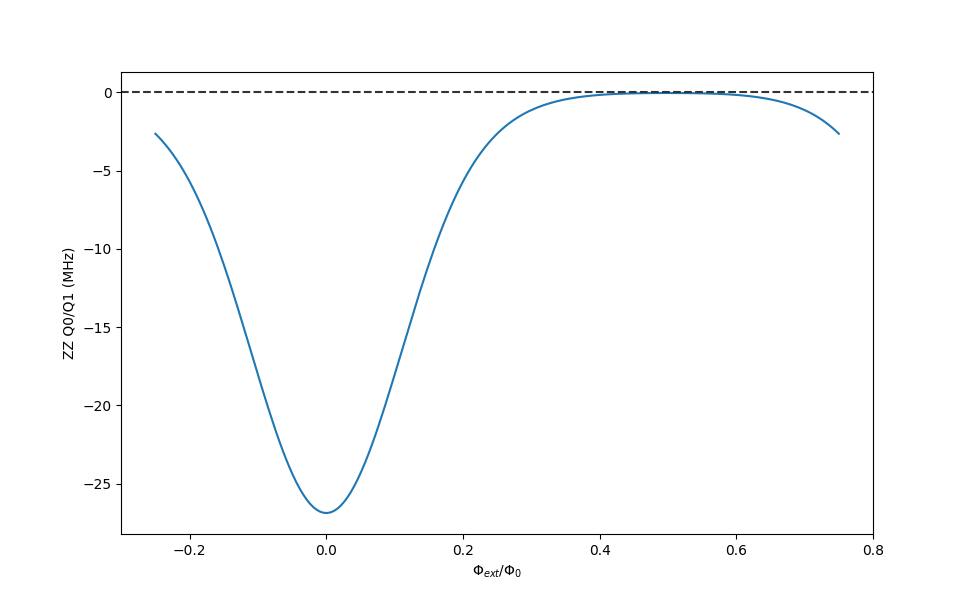

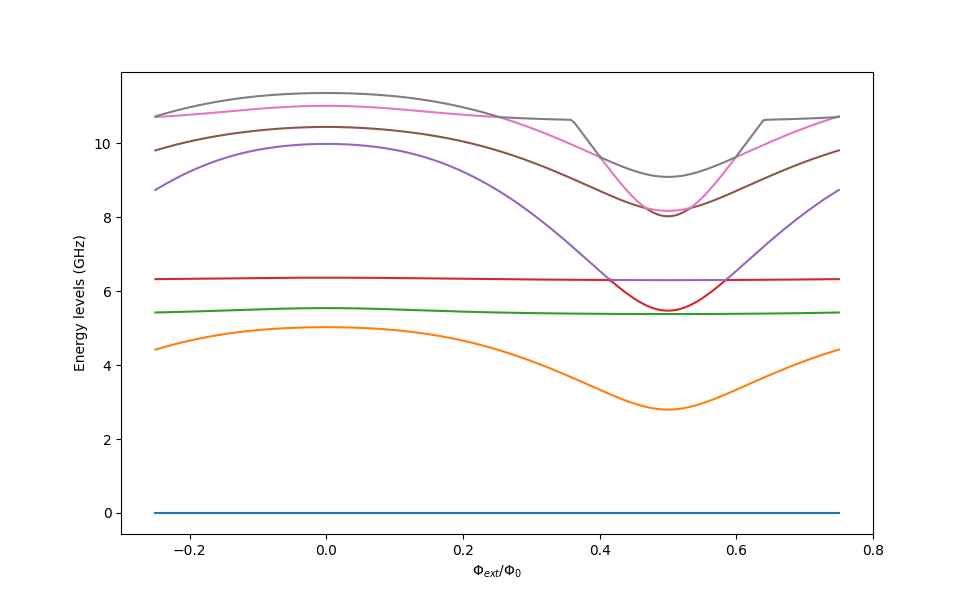

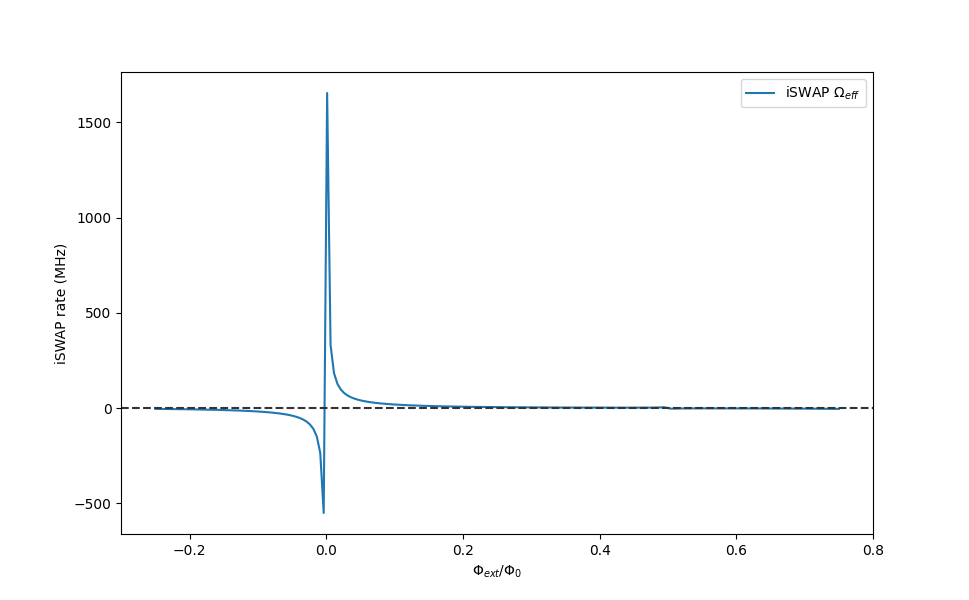

In [51]:
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_flux))
print('Min ZZ (MHz)', 1e3*ZZ_01_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_flux))
print('Max ZZ (MHz)', 1e3*ZZ_01_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

plt.figure()
plt.plot(phi_exts, ZZ_01_flux*1e3)
plt.axhline(0, linestyle='--', color='0.2')
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('ZZ Q0/Q1 (MHz)')
plt.show()


plt.figure()
nlevels = 8
for level in range(nlevels):
    plt.plot(phi_exts, evals_flux[:, level]/2/np.pi)
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('Energy levels (GHz)')
plt.show()


plt.figure()
# plt.plot(phi_exts, wc_flux/2/np.pi, label='$f_{coupler}$')
# plt.plot(phi_exts, dwcdflux/2/np.pi, label='$df_{coupler}/d\Phi$')
plt.plot(phi_exts, 1e3*Omega_eff_flux, label='iSWAP $\Omega_{eff}$')
# plt.plot(phi_exts, 1/(Del_0minus_flux * Del_1minus_flux))
plt.axhline(0, linestyle='--', color='0.2')
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('iSWAP rate (MHz)')
plt.legend()
plt.show()

In [74]:
wd0 = qram.get_base_wd('egg', 'gge')

t_pulse = 200

times = np.linspace(0, t_pulse, 200)

seq = PulseSequence(start_time=0)
qram.flux_drive_sequence(dc_phi_ext=0.050, seq=seq, seq_func=seq.flat_top_pulse, wd=wd0, amp=0.05, t_pulse=t_pulse, pulse_levels=('egg', 'gge'), drive_qubit=2, t_rise=5)

psi0 = qram.state('egg')
result = qt.mesolve(qram.H_solver_flux_drive(seq=seq), psi0, times, progress_bar=True, options=qt.Options(nsteps=1000)).states

0.05
10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.15s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.0%. Run time:   0.30s. Est. time left: 00:00:00:00
50.0%. Run time:   0.37s. Est. time left: 00:00:00:00
60.0%. Run time:   0.45s. Est. time left: 00:00:00:00
70.0%. Run time:   0.52s. Est. time left: 00:00:00:00
80.0%. Run time:   0.60s. Est. time left: 00:00:00:00
90.0%. Run time:   0.67s. Est. time left: 00:00:00:00
Total run time:   0.78s


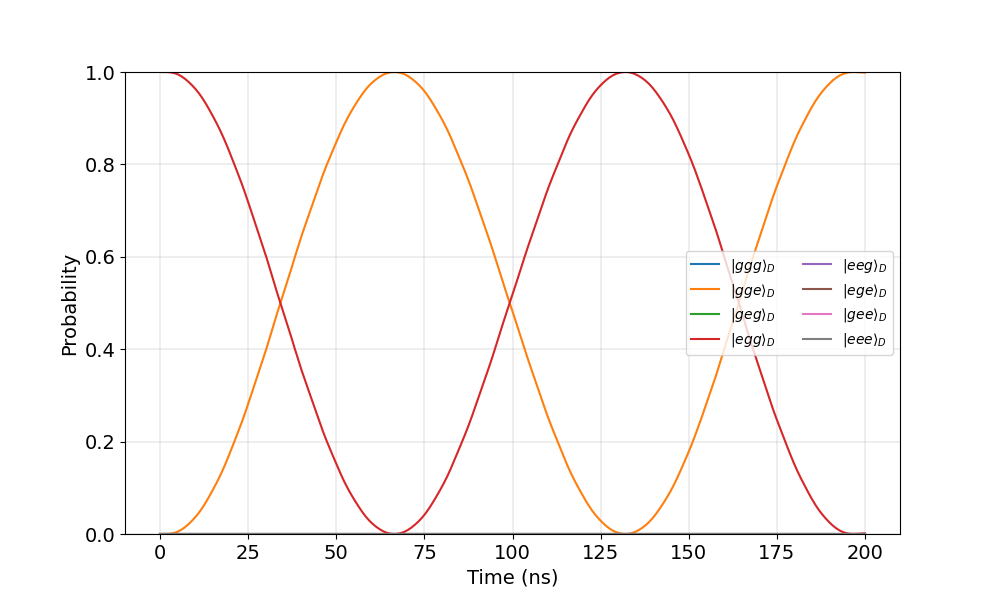

In [75]:
saveplot = False

plt.figure(figsize=(10,6))
if saveplot: plt.style.use('dark_background')

plot_states = ['ggg', 'gge', 'geg', 'egg', 'eeg', 'ege', 'gee', 'eee']
prob_states = dict()
for state in plot_states:
    psi = qram.state(state)
    prob_states.update({state:[np.abs(psi.overlap(result[t]))**2 for t in range(len(times))]})

for state in plot_states:
    plt.plot(times, prob_states[state], label=rf'$|{state}\rangle_D$')

plt.legend(fontsize=10, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)

if saveplot:
    plot_filename = 'qram_protocol_simulated.png'
    plt.savefig(plot_filename, format='png', bbox_inches='tight', transparent = True)
    print('Saved', plot_filename)

plt.show()

# 4Q with coupler

### Sweep for parameters

In [52]:
# cutoffs = [5, 5, 5, 5, 5]
cutoffs = [4]*5

# good:
EJs = np.array([27.5, 25.3, 26.95, 29.7, 32.0]) # GHz
ECs = np.array([0.190, 0.150, 0.170, 0.190, 0.115]) # GHz
dEJ = 0.30 # (EJ1 - EJ2)/(EJ1 + EJ2)
gs =  1e-3*np.array([25.6, 150, 150, 5, 5, 315, -252, 25, 25]) # gs=[01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]

print('AT FLUX 0')
phi_ext = 0.0
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], EJ_flux(EJs[-1], phi_ext, dEJ)]/ECs))

# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

print()
print('AT FLUX 0.5')
phi_ext = 0.5
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], EJ_flux(EJs[-1], phi_ext, dEJ)]/ECs))


[27.5  25.3  26.95 29.7  32.  ]
AT FLUX 0
bare qubit freqs (GHz) 6.269224812331601 5.35558289957299 5.878923144462036 6.5231100584366075 5.3082794966011875
bare alphas (GHz) -0.20456524844745516 -0.16052334126088752 -0.18236083188011065 -0.203927986305656 -0.12107959858603579
EJ/EC 144.73684210526315 168.66666666666669 158.52941176470586 156.3157894736842 278.2608695652174

AT FLUX 0.5
bare qubit freqs (GHz) 6.269224812331601 5.35558289957299 5.878923144462036 6.5231100584366075 2.8518893460383126
bare alphas (GHz) -0.20456524844745516 -0.16052334126088752 -0.18236083188011065 -0.203927986305656 -0.12726797557763447
EJ/EC 144.73684210526315 168.66666666666669 158.52941176470586 156.3157894736842 83.4782608695652


### Minimize ZZ

In [53]:
ZZ_01_flux = []
ZZ_01_fe_flux = []
phi_exts = np.linspace(-0.25, 0.75, num=61)
# phi_exts = np.linspace(-0.25, 0.75, num=21)
print(phi_exts)
evals_flux = []
esys_flux = []
qubit_freqs_v_flux = np.zeros(shape=(qram.nqubits, 2, len(phi_exts)))
plot_levels = ['efggg', 'gfggg']
plot_levels_wds = [[], []]

for i_phi, phi_ext_i in enumerate(tqdm(phi_exts)):
    qram = QSwitchTunableTransmonCoupler(
        EJs=EJs,
        ECs=ECs,
        dEJ=dEJ,
        phi_ext=phi_ext_i,
        gs=gs,
        is2Q=False,
        cutoffs=cutoffs,
        useZZs=False,
    )
    evals, evecs = qram.esys
    evals_flux.append(evals)
    esys_flux.append(qram.esys)
    ZZ_01_flux.append(qram.get_ZZ(1, 0, qA_state='e', qB_state='e'))
    ZZ_01_fe_flux.append(qram.get_ZZ(1, 0, qA_state='f', qB_state='e'))
    for q in range(5):
        gstate = 'ggggg'
        estate = gstate[:q] + 'e' + gstate[q+1:]
        fstate = gstate[:q] + 'f' + gstate[q+1:]
        qubit_freqs_v_flux[q][0][i_phi] = qram.get_base_wd(gstate, estate)
        qubit_freqs_v_flux[q][1][i_phi] = qram.get_base_wd(gstate, fstate)
        # print(qubit_freqs_v_flux)
    for i, level in enumerate(plot_levels):
        wds = plot_levels_wds[i]
        wds.append(qram.get_base_wd('ggggg', level))

ZZ_01_flux = np.array(ZZ_01_flux)
ZZ_01_fe_flux = np.array(ZZ_01_fe_flux)
evals_flux = np.array(evals_flux)
qubit_freqs_v_flux = np.array(qubit_freqs_v_flux)
plot_levels_wds = np.array(plot_levels_wds)

[-0.25       -0.23333333 -0.21666667 -0.2        -0.18333333 -0.16666667
 -0.15       -0.13333333 -0.11666667 -0.1        -0.08333333 -0.06666667
 -0.05       -0.03333333 -0.01666667  0.          0.01666667  0.03333333
  0.05        0.06666667  0.08333333  0.1         0.11666667  0.13333333
  0.15        0.16666667  0.18333333  0.2         0.21666667  0.23333333
  0.25        0.26666667  0.28333333  0.3         0.31666667  0.33333333
  0.35        0.36666667  0.38333333  0.4         0.41666667  0.43333333
  0.45        0.46666667  0.48333333  0.5         0.51666667  0.53333333
  0.55        0.56666667  0.58333333  0.6         0.61666667  0.63333333
  0.65        0.66666667  0.68333333  0.7         0.71666667  0.73333333
  0.75      ]


100%|██████████| 61/61 [01:08<00:00,  1.12s/it]


Min ZZ (MHz) -0.04117978949302881 at phi_ext/phi0 0.5
Max ZZ (MHz) -27.533889242086218 at phi_ext/phi0 0.0


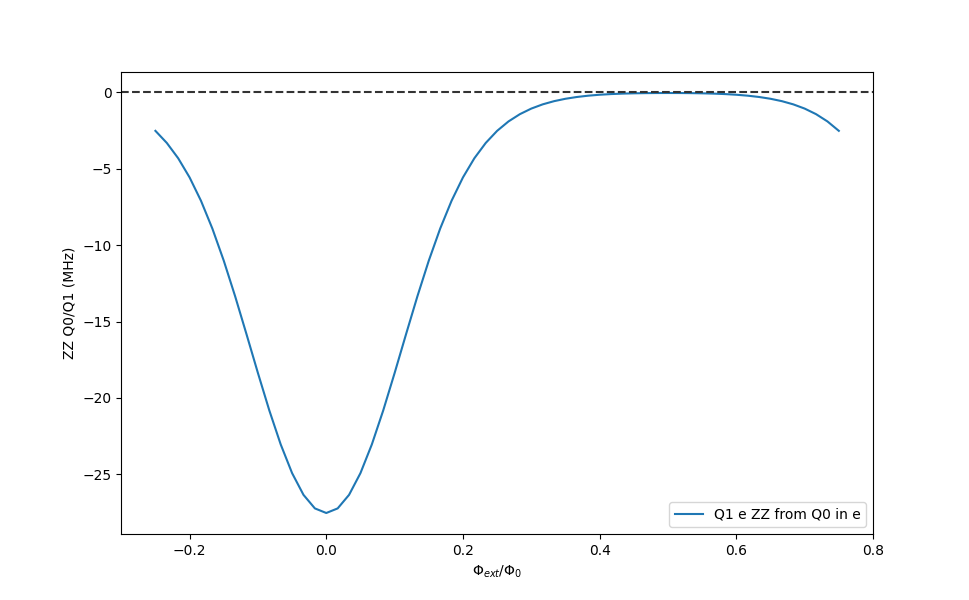

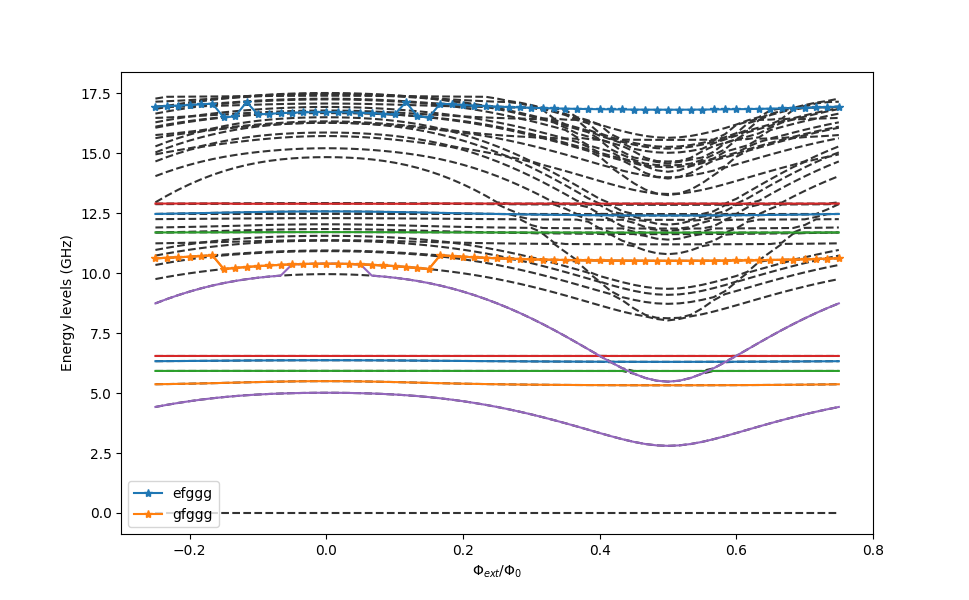

In [56]:
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_flux))
print('Min ZZ (MHz)', 1e3*ZZ_01_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_flux))
print('Max ZZ (MHz)', 1e3*ZZ_01_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

plt.figure()
plt.plot(phi_exts, ZZ_01_flux*1e3, label='Q1 e ZZ from Q0 in e')
# plt.plot(phi_exts, ZZ_01_fe_flux*1e3, label='Q1 f ZZ from Q0 in e')
plt.axhline(0, linestyle='--', color='0.2')
plt.legend()
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('ZZ Q0/Q1 (MHz)')
plt.show()


plt.figure()
nlevels = 40
for level in range(nlevels):
    plt.plot(phi_exts, evals_flux[:, level]/2/np.pi, '--', color='0.2')
for q in range(len(qubit_freqs)):
    for level in range(qubit_freqs_v_flux.shape[1]):
            plt.plot(phi_exts, qubit_freqs_v_flux[q, level, :]/2/np.pi, default_colors[q])
for plot_level_name, wds in zip(plot_levels, plot_levels_wds):
    plt.plot(phi_exts, wds/2/np.pi, '*-', label=plot_level_name)
plt.legend()
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('Energy levels (GHz)')
plt.show()


# plt.figure()
# # plt.plot(phi_exts, wc_flux/2/np.pi, label='$f_{coupler}$')
# # plt.plot(phi_exts, dwcdflux/2/np.pi, label='$df_{coupler}/d\Phi$')
# plt.plot(phi_exts, 1e3*Omega_eff_flux, label='iSWAP $\Omega_{eff}$')
# # plt.plot(phi_exts, 1/(Del_0minus_flux * Del_1minus_flux))
# plt.axhline(0, linestyle='--', color='0.2')
# plt.xlabel('$\Phi_{ext}/\Phi_0$')
# plt.ylabel('iSWAP rate (MHz)')
# plt.legend()
# plt.show()

## Simulate pulses

In [50]:
phi_ext_smallZZ = 0.5
phi_ext_largeZZ = 0
phi_ext_large_g01 = 0.050

phase_IL = 0
phase_IR = 0

amp_pi = 0.010 # pi pulse in the protocol
amp_swap_q1q2 = 0.010 # swap q1/q2 fg -> ge
amp_swap_q1q3 = 0.100 # swap q1/q3 fg -> ge

t_flux_rise = 20

In [126]:
cutoffs = [4]*5

# good:
EJs = np.array([27.5, 25.3, 26.95, 29.7, 32.0]) # GHz
ECs = np.array([0.190, 0.150, 0.170, 0.190, 0.115]) # GHz
dEJ = 0.30 # (EJ1 - EJ2)/(EJ1 + EJ2)
gs =  1e-3*np.array([25.6, 150, 150, 5, 5, 315, -252, 25, 25]) # gs=[01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]

phi_ext = 0.0
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)


# ---- CONSTRUCT SEQUENCE -----

flux_seq = []

seq = PulseSequence(start_time=0)

qram.update_H(phi_ext=phi_ext_smallZZ)
seq.flux_transition(t_begin_transit=0, t_flux_rise=0, flux_f=phi_ext_smallZZ)

# ---- PREPARE Q1 and Q2
# |switch, input, output1, output2, switch/input coupler>


# # |0+1>|0> |switch>|input>
# wd01 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'egggg', amp=amp_pi, drive_qubit=0, type='gauss', wd=qram.get_base_wd('ggggg', 'egggg', phi_ext=phi_ext_smallZZ), phase=-np.pi/2, pihalf=True, phi_ext=phi_ext_smallZZ)

# # |0+1>|1>
# wd00 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'egggg', amp=amp_pi, drive_qubit=0, type='gauss', phase=-np.pi/2, pihalf=True)
# wd01 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'geggg', amp=amp_pi, drive_qubit=1, type='gauss', phase=0, pihalf=False)

# # |1>|0+1>
# wd00 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'egggg', amp=amp_pi, drive_qubit=0, type='gauss', phase=0, pihalf=False)
# wd01 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'geggg', amp=amp_pi, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True)

# |0+1>|0+1>
wd00 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'egggg', wd=qram.get_base_wd('ggggg', 'egggg'), amp=amp_pi, drive_qubit=0, type='gauss', phase=-np.pi/2, pihalf=True)
phase_I = -np.pi/2
wd01 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'geggg', wd=qram.get_base_wd('ggggg', 'geggg'), amp=amp_pi, drive_qubit=1, type='gauss', phase=phase_I, pihalf=True)

# # |0+1>|0+i1>
# wd00 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'egggg', amp=amp_pi, drive_qubit=0, type='gauss', phase=-np.pi/2, pihalf=True)
# phase_I = -np.pi
# wd01 = qram.add_sequential_pi_pulse(seq, 'ggggg', 'geggg', amp=amp_pi, drive_qubit=1, type='gauss', phase=phase_I, pihalf=True)



# ---- FORWARD PROTOCOL OPTION 1 ---- 

qram.update_H(phi_ext=phi_ext_largeZZ)
# seq.flux_transition(t_begin_transit=0, t_flux_rise=0, flux_f=phi_ext_largeZZ)
seq.flux_transition(t_begin_transit=max(seq.get_start_times() + seq.get_pulse_lengths()), t_flux_rise=t_flux_rise, flux_f=phi_ext_largeZZ)

# wd1 = qram.add_sequential_pi_pulse(seq, 'geggg', 'ggfgg', amp=amp_swap_q1q2, drive_qubit=2, type='flat_top', phase=phase_IL, pihalf=False, t_rise=5)
# wd1 = 39.019602373389404
wd1 = qram.add_sequential_pi_pulse(seq, 'geggg', 'ggfgg', amp=amp_swap_q1q2, wd=wd1, drive_qubit=2, type='flat_top', phase=phase_IL, pihalf=False, t_rise=5)
print('wd1', wd1, '\n')

# wd2 = qram.add_sequential_pi_pulse(seq, 'eeggg', 'eggfg', amp=amp_swap_q1q3, drive_qubit=3, type='flat_top', phase=phase_IR, pihalf=False, t_rise=5, t_offset=-seq.get_pulse_lengths()[-1])
# wd2 = 46.674426209154284
wd2 = qram.add_sequential_pi_pulse(seq, 'eeggg', 'eggfg', amp=amp_swap_q1q3, wd=wd2, drive_qubit=3, type='flat_top', phase=phase_IR, pihalf=False, t_rise=5, t_offset=-seq.get_pulse_lengths()[-1])
print('wd2', wd2, '\n')


qram.update_H(phi_ext=phi_ext_smallZZ)
seq.flux_transition(t_begin_transit=max(seq.get_start_times() + seq.get_pulse_lengths()), t_flux_rise=t_flux_rise, flux_f=phi_ext_smallZZ)

# wd3 = qram.add_sequential_pi_pulse(seq, 'ggfgg', 'ggegg', amp=amp_pi, drive_qubit=2, type='gauss', phase=0, pihalf=False)
# wd3 = 36.22550136896158
wd3 = qram.add_sequential_pi_pulse(seq, 'ggfgg', 'ggegg', wd=wd3, amp=amp_pi, drive_qubit=2, type='gauss', phase=0, pihalf=False)
print('wd3', wd3, '\n')

# wd4 = qram.add_sequential_pi_pulse(seq, 'gggfg', 'gggeg', amp=amp_pi, drive_qubit=3, type='gauss', phase=0, pihalf=False, t_offset=-seq.get_pulse_lengths()[-1])
# wd4 = 39.88565481653143
wd4 = qram.add_sequential_pi_pulse(seq, 'gggfg', 'gggeg', wd=wd4, amp=amp_pi, drive_qubit=3, type='gauss', phase=0, pihalf=False, t_offset=-seq.get_pulse_lengths()[-1])
print('wd4', wd4, '\n')



# ---- FORWARD PROTOCOL OPTION 2 ---- 
# wd1 = qram.add_sequential_pi_pulse(seq, 'geggg', 'gfggg', wd=qram.get_base_wd('geggg', 'gfggg'), amp=amp_pi, drive_qubit=1, type='gauss', phase=0, pihalf=False)

# qram.update_H(phi_ext=phi_ext_largeZZ)
# seq.flux_transition(t_begin_transit=max(seq.get_start_times() + seq.get_pulse_lengths()), t_flux_rise=t_flux_rise, flux_f=phi_ext_largeZZ)

# wd1 = qram.add_sequential_pi_pulse(seq, 'gfggg', 'ggegg', amp=amp_swap_q1q2, drive_qubit=1, type='flat_top', phase=phase_IL, pihalf=False)
# wd1 = 27.975164674397657
# wd1 = qram.add_sequential_pi_pulse(seq, 'gfggg', 'ggegg', amp=amp_swap_q1q2, wd=wd1, drive_qubit=1, type='flat_top', phase=phase_IL, pihalf=False, t_rise=5)

# # wd1 = qram.add_sequential_pi_pulse(seq, 'efggg', 'eggeg', amp=amp_swap_q1q3, drive_qubit=1, type='flat_top', phase=phase_IR, pihalf=False)
# wd2 = 23.75453243917347
# wd2 = qram.add_sequential_pi_pulse(seq, 'efggg', 'eggeg', amp=amp_swap_q1q3, wd=wd2, drive_qubit=1, type='flat_top', phase=phase_IR, pihalf=False, t_rise=5)


wd1 39.019602373389404 

wd2 46.674426209154284 

wd3 36.22550136896158 

wd4 39.88565481653143 



### Plot pulse seq envelopes

[6.298024718760405, 5.322105043124635, 6.210162595205175, 7.428465647164819, 5.7654676088524575, 6.347999122508041] (GHz)
[ 41.96969235  43.80503413 291.114233   173.64928857  63.02870792
  59.9980352 ] (ns)
total pulse length 673.5649911593226 ns


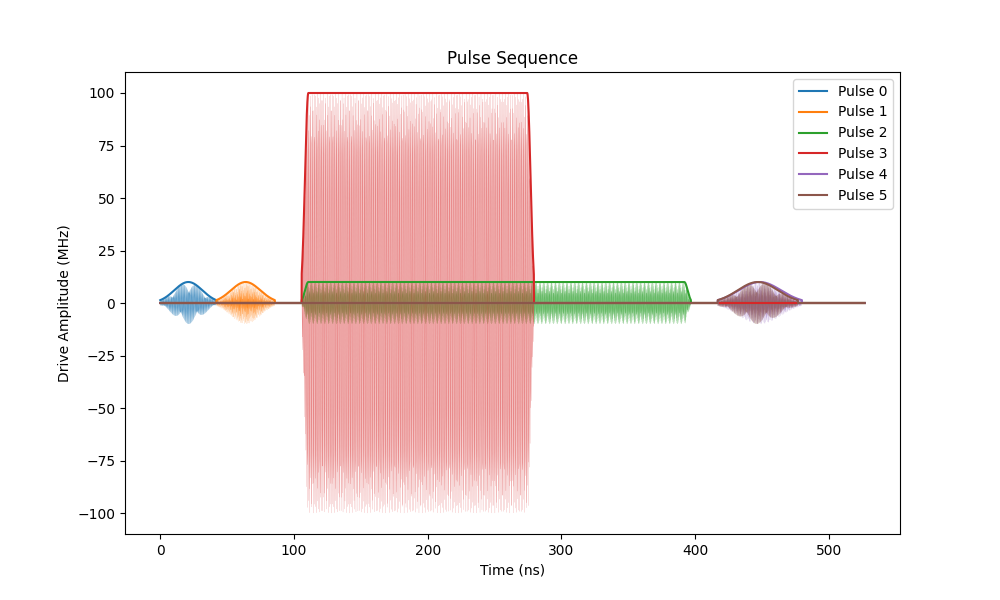

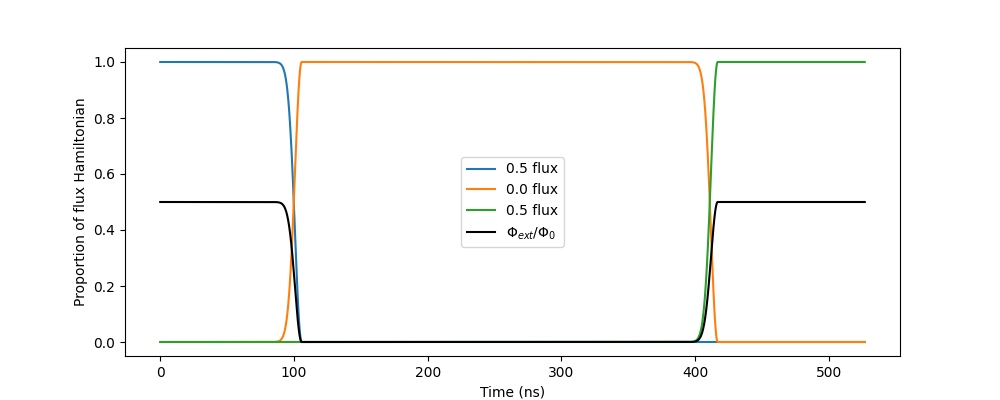

In [135]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_freqs = seq.get_pulse_freqs()
pulse_lens = seq.get_pulse_lengths()
drive_funcs = seq.get_pulse_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

times = np.linspace(0, seq.get_start_times()[-1] + seq.get_pulse_lengths()[-1] + 50, 5000)
# times = np.linspace(0, sum(seq.get_pulse_lengths())+30, 200)
# times = np.linspace(0, sum(seq.get_pulse_lengths()), 50)
# times = np.linspace(0, seq.get_pulse_lengths()[-1], 900)


flat_times = np.array(times).flatten()
# drive_v_times = []
envelope_v_times = []
plt.figure(figsize=(10, 6))
for i in range(len(envelope_seq)):
    plt.plot(flat_times, [1e3*drive_funcs[i](t) for t in flat_times], linewidth=0.1, color=default_colors[i]) #, color='0.7')
for i in range(len(envelope_seq)):
    if isinstance(envelope_seq[i], list) and len(envelope_seq[i]) == 2:
        envelope_v_time_I = [pulse_amps[i]*envelope_seq[i][0](t)*1e3 for t in flat_times]
        envelope_v_time_Q = [pulse_amps[i]*envelope_seq[i][1](t)*1e3 for t in flat_times]
        plt.plot(flat_times, envelope_v_time_I, label=f'Pulse {i} I')
        plt.plot(flat_times, envelope_v_time_Q, label=f'Pulse {i} Q')
    else:
        envelope_v_time = [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in flat_times]
        envelope_v_times.append(envelope_v_time)
        plt.plot(flat_times, envelope_v_time, label=f'Pulse {i}', color=default_colors[i])
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 20)
plt.title('Pulse Sequence')
plt.legend()
plt.show()


plt.figure(figsize=(10, 4))
window_funcs, flux_seq = seq.construct_flux_transition_map()
flux_at_times = np.zeros_like(times)
for window_func, flux in zip(window_funcs, flux_seq):
    window_at_times = np.array([window_func(t) for t in times])
    flux_at_times += flux * window_at_times
    plt.plot(times, window_at_times, label=f'{flux} flux')
plt.plot(times, flux_at_times, 'k', label='$\Phi_{ext}/\Phi_0$')
# plt.ylim(-1, 1)
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Proportion of flux Hamiltonian')
plt.show()

## Run simulation

In [132]:
psi0 = qram.state('ggggg', phi_ext=flux_seq[0])
# psi0 = (qram.state('gfggg', phi_ext=flux_seq[0]) + qram.state('efggg', phi_ext=flux_seq[0])).unit()
# psi0 = (qram.state('geggg', phi_ext=flux_seq[0]) + qram.state('eeggg', phi_ext=flux_seq[0])).unit()

H_solver = qram.H_solver_flux_sequence(seq=seq)
result = qram.evolve_flux_sequence(psi0=psi0, times=times, H_solver=H_solver, progress=True, nsteps=10000)

10.0%. Run time:  16.05s. Est. time left: 00:00:02:24
20.0%. Run time:  32.83s. Est. time left: 00:00:02:11
30.0%. Run time:  50.26s. Est. time left: 00:00:01:57
40.0%. Run time:  67.85s. Est. time left: 00:00:01:41
50.0%. Run time:  85.59s. Est. time left: 00:00:01:25
60.0%. Run time: 103.26s. Est. time left: 00:00:01:08
70.0%. Run time: 120.93s. Est. time left: 00:00:00:51
80.0%. Run time: 138.94s. Est. time left: 00:00:00:34
90.0%. Run time: 156.30s. Est. time left: 00:00:00:17
Total run time: 172.79s


Plot population in reference states

In [138]:
saveplot = False

if saveplot: plt.style.use('dark_background')

plot_states = ['ggggg', 'egggg', 'geggg', 'ggegg', 'gggeg', 'eeggg', 'egegg', 'eggeg', 'geegg', 'gegeg', 'ggeeg', 'gfggg', 'efggg', 'ggfgg', 'eggfg']
prob_states = dict()

sample_times = times[::50]
flux_at_sample_times = flux_at_times[::50]
print('Num sample points', len(sample_times))


# Construct reference eigenstates at different times (since flux could change over time)
ref_states_sample_times = dict()
last_flux = None
esys = None
for t in range(len(sample_times)):
    if flux_at_sample_times[t] != last_flux:
        coupler_H0, H0, H = qram.get_H_at_phi_ext(flux_at_sample_times[t])
        esys = H.eigenstates()
    for state in plot_states:
        if state not in ref_states_sample_times.keys():
            ref_states_sample_times.update({state:[]})
        if flux_at_sample_times[t] != last_flux:
            ref_states_sample_times[state].append(qram.state(state, esys=esys))
        else:
            ref_states_sample_times[state].append(ref_states_sample_times[state][-1])
    last_flux = flux_at_sample_times[t]

for state in plot_states:
    prob_state = []
    for t_sample in range(len(sample_times)):
        # t_sample = np.argmin(np.abs(sample_times - t))
        t = np.argmin(np.abs(times - sample_times[t_sample]))
        prob_state.append(np.abs(ref_states_sample_times[state][t_sample].overlap(result[t]))**2)
    prob_states.update({state:prob_state})


Num sample points 100


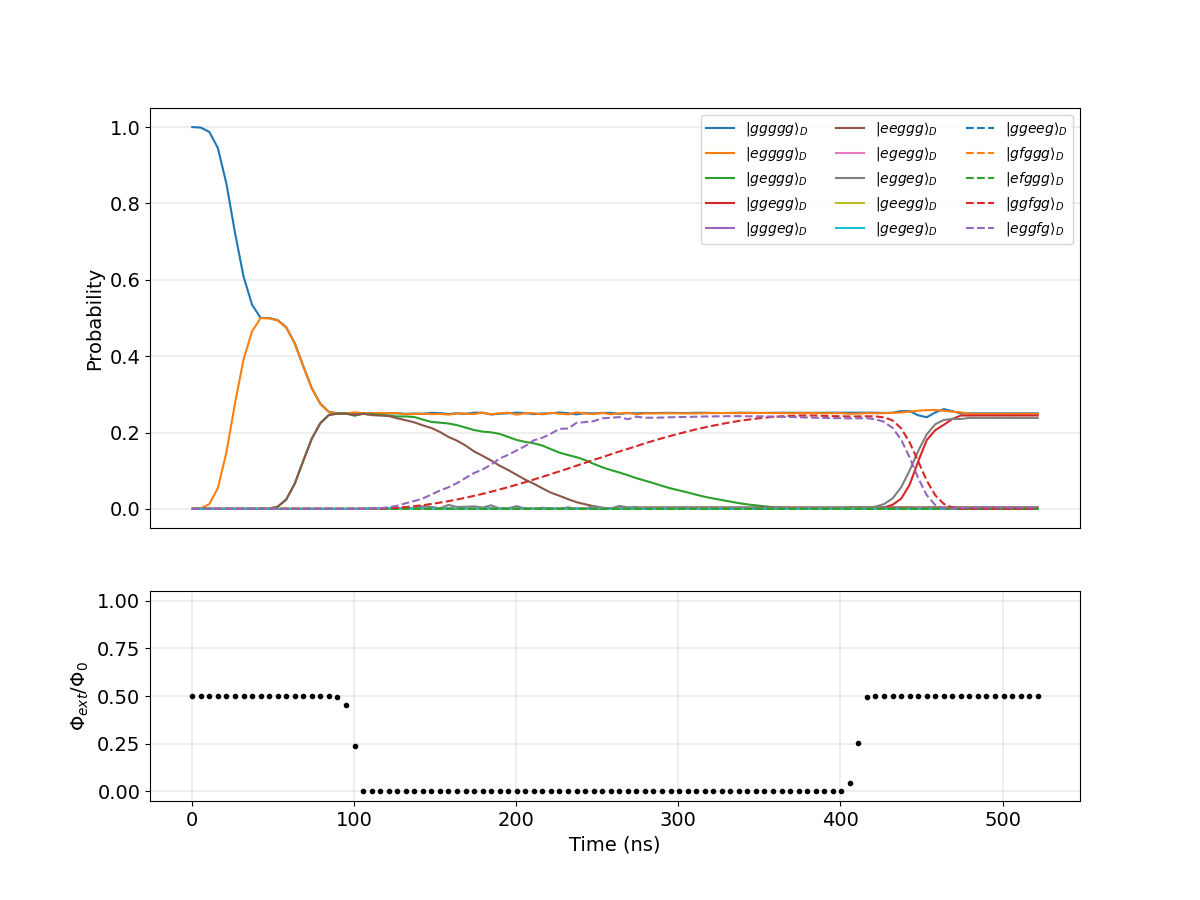

In [144]:

fig, axs = plt.subplots(2, 1, figsize=(12, 9), gridspec_kw={'height_ratios': [2, 1]})
ax1, ax2 = axs

plt.sca(ax1)
for i, state in enumerate(plot_states):
    color_ind = i%len(default_colors)
    linestyle_ind = (i//len(default_colors)) % len(linestyle_cycle)
    marker_ind = (i//(len(default_colors)*len(linestyle_cycle))) % len(marker_cycle)
    plt.plot(sample_times, prob_states[state], label=rf'$|{state}\rangle_D$', color=default_colors[color_ind], linestyle=linestyle_cycle[linestyle_ind], marker=marker_cycle[marker_ind], markersize=3)

plt.legend(fontsize=10, ncol=3)
plt.ylim(-0.05, 1.05)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xticks([])
# plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)


plt.sca(ax2)
plt.plot(sample_times, flux_at_sample_times, 'k.')
plt.ylim(-0.05, 1.05)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('$\Phi_{ext}/\Phi_0$', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)

if saveplot:
    plot_filename = 'qram_protocol_simulated.png'
    plt.savefig(plot_filename, format='png', bbox_inches='tight', transparent = True)
    print('Saved', plot_filename)

plt.show()

Get non zero levels

In [134]:
max_prob = 0.001

T = times[-1] # ns
# T = 80 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
probs = dict()
print(f"Non-zero levels to {max_prob*100}% error at T={T}:")

# coupler_H0, H0, H = qram.get_H_at_phi_ext(flux_at_times[T])
coupler_H0, H0, H = qram.get_H_at_phi_ext(flux_at_sample_times[99])
esys = H.eigenstates()

for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                for i5 in range(cutoffs[4]):
                    prob = np.abs(qram.state([i1, i2, i3, i4, i5], esys=esys).overlap(result[T]))**2
                    if prob > max_prob:
                        probs.update({qram.level_nums_to_name([i1, i2, i3, i4, i5]):prob})
                        sum_psi += prob
probs = sorted(probs.items(), key=lambda item:-item[1])
for level, prob in probs:
    print(level, '(%):', prob*100)
print('Sum probabilities (%):', sum_psi*100)

Non-zero levels to 0.1% error at T=4999:
ggggg (%): 25.03718027074804
egggg (%): 24.90877716633582
ggegg (%): 24.47287052442949
eggeg (%): 23.823195713913314
eeggg (%): 0.40034656944833313
eggfg (%): 0.3498657999957255
geggg (%): 0.29133465436735195
egghg (%): 0.2845236487493779
fggeg (%): 0.23809774943003462
Sum probabilities (%): 99.8061920974175


Plotting functions

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=18)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels, fontsize=18)
    plt.yticks(np.arange(len(mat)), labels, fontsize=18)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=16)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
    cbar.ax.tick_params(labelsize=14)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_sim, rho_id=None, title='', cmax=None, savetitle=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(12, 4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(10, 8))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_sim), ax=ax1, title="Re[$\\rho_{Sim}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_sim), ax=ax2, title="Im[$\\rho_{Sim}$]", labels=labels, cmax=cmax, show=False)
    if rho_id is not None:
        show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
        show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    
    plt.show()


def show_plot_rho_3d(rho_sim, rho_id=None, title='', zmin=None, zmax=None, width=0.75, elev=30, azim=-20, savetitle=None):
    if savetitle is not None: plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    _xx, _yy = np.meshgrid(np.arange(4), np.arange(4))
    x, y = _xx.ravel(), _yy.ravel()
    if zmax is None: zmax = np.max(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)]))
    if zmin is None: zmin = np.min((0, np.min(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)]))))

    ax1.view_init(elev=elev, azim=azim)
    ax1.set_xticks(np.arange(4), minor=False)
    ax1.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax1.set_yticks(np.arange(1, 5, 1), minor=False)
    ax1.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.real(rho_id).flatten(), edgecolor='k', alpha=0)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.real(rho_sim).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax1.set_zlim(zmin, zmax)
    ax1.set_title("Re[$\\rho$]", fontsize=20)

    ax2.view_init(elev=elev, azim=azim)
    ax2.set_xticks(np.arange(4), minor=False)
    ax2.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax2.set_yticks(np.arange(1, 5, 1), minor=False)
    ax2.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax2.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.imag(rho_id).flatten(), edgecolor='k', alpha=0)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.imag(rho_sim).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax2.set_zlim(zmin, zmax)
    ax2.set_title("Im[$\\rho$]", fontsize=20)

    plt.suptitle(title, fontsize=22)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent=True)
    plt.show()